In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd

In [2]:
n_agents = 2
actions_space = np.arange(1.2, 2.0, 0.04)
n_actions = actions_space.size
# state_ravel = (n_actions,)*n_agents

In [3]:
quality = np.ones(n_agents)*2
margin_cost = np.ones(n_agents)
horizon = 1/4
a0 = 0
def replay_classic_reward(action):
    # Compute profits for all agents
    price = actions_space[action]
    demand = np.exp((quality - price) / horizon)
    demand = demand / (np.sum(demand) + np.exp(a0 / horizon))
    reward = np.multiply(price - margin_cost, demand)
    return reward

In [4]:
with open('DQN_LAMn005_act.pickle', 'rb') as fp:
    LAMn_price = pickle.load(fp)

with open('DQN_LAMn005_heat.pickle', 'rb') as fp:
    LAMn_heat = pickle.load(fp)
    
with open('DQN_LAM5_act.pickle', 'rb') as fp:
    LAM5_price = pickle.load(fp)

with open('DQN_LAM5_heat.pickle', 'rb') as fp:
    LAM5_heat = pickle.load(fp)

In [7]:
with open('DQN_LAM0_act.pickle', 'rb') as fp:
    LAM0_price = pickle.load(fp)

with open('DQN_LAM0_heat.pickle', 'rb') as fp:
    LAM0_heat = pickle.load(fp)

In [8]:
monopoly = replay_classic_reward([18, 18])[0]
nash = replay_classic_reward([7, 7])[0]
total_reward = np.zeros(5)
for ins in range(5):
    for period in range(1000):
        total_reward[ins] += replay_classic_reward(LAM5_price[ins][period].astype(int)).mean()
origin_ratio = (total_reward/1000 - nash)/(monopoly - nash)

In [12]:
# These are original ratios of long-run prices
LAMn_ratio = np.array([0.18604868, 0.14171286, -0.28213199, -0.30892387, -0.00169872])
LAM0_ratio = np.array([1.53249551e-01, -2.33589361e-01,  2.11199361e-01, -2.48372841e-02, 8.20857317e-15])
LAM5_ratio = np.array([0.46332573, 0.91060291, 0.64665479, 0.9516298 , 0.7330381])
n_instance = len(LAM0_price)

In [13]:
df1 = pd.DataFrame({'Ratio':LAM0_ratio, 'Lambda':np.zeros(n_instance)})
df2 = pd.DataFrame({'Ratio':LAM5_ratio, 'Lambda':np.ones(n_instance)*5})
df3 = pd.DataFrame({'Ratio':LAMn_ratio, 'Lambda': -np.ones(n_instance)*0.005})
frames = [df1, df2, df3]
df = pd.concat(frames)

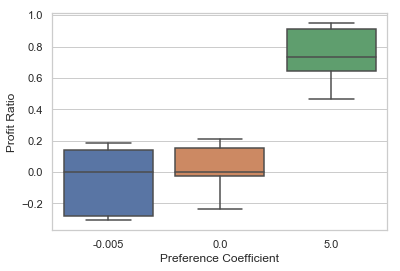

In [14]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Lambda", y="Ratio", data=df)
ax.set_xlabel("Preference Coefficient") # , fontsize=14)
ax.set_ylabel("Profit Ratio")
plt.savefig('dqn_box.eps', format='eps', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [8]:
# Ratio matrix calculator
N = 200000
monopoly = replay_classic_reward([18, 18])[0]
nash = replay_classic_reward([7, 7])[0]

ss = np.random.SeedSequence(12345)
# Last a few rngs for sampling memories
child_seeds = ss.spawn(n_agents)
rng = [np.random.default_rng(s) for s in child_seeds]

sim_ratio = np.zeros((n_instance, n_instance))

for agent0 in range(n_instance):
    for agent1 in range(n_instance):
        sim_Q = np.zeros((n_agents, n_actions, n_actions))
        sim_Q[0, :, :] = LAM5_heat[agent0][0, :, :]
        sim_Q[1, :, :] = LAM5_heat[agent1][1, :, :]
        init = np.zeros(n_agents, dtype=int)
        for i in range(n_agents):
            init[i] = rng[i].integers(0, n_actions, size=1)
        state = init
#         state = np.random.randint(0, n_actions**n_agents, size=1)
        action = np.zeros(n_agents, dtype=int)
        reward = np.zeros(n_agents)
        for k in range(N):
            # For each agent, select and perform an action
            for i in range(n_agents):
                action[i] = sim_Q[i, state[0], state[1]]
            if k > N - 10000:
                reward += replay_classic_reward(action)
            # Move to the next state
            state = action
            avg = np.sum(reward)/10000/n_agents
            sim_ratio[agent0, agent1] = (avg - nash)/(monopoly - nash)
        print('Instance', agent0, 'vs', agent1, avg, 'ratio', sim_ratio[agent0, agent1])

Instance 0 vs 0 0.25513036767955743 ratio 0.26205335191400614
Instance 0 vs 1 0.25513036767955743 ratio 0.26205335191400614
Instance 0 vs 2 0.23146117432071428 ratio 0.049930746409859096
Instance 0 vs 3 0.21737338361739547 ratio -0.0763236140357874
Instance 0 vs 4 0.25779578006249126 ratio 0.2859406982565338
Instance 1 vs 0 0.23343143914734474 ratio 0.06758820106924578
Instance 1 vs 1 0.24221853798700796 ratio 0.14633791900145549
Instance 1 vs 2 0.2230471394001759 ratio -0.025475583797023547
Instance 1 vs 3 0.2110835387972722 ratio -0.1326930158668315
Instance 1 vs 4 0.2494310011445702 ratio 0.21097579887720408
Instance 2 vs 0 0.1994135135727298 ratio -0.23727943414475652
Instance 2 vs 1 0.2110835387972722 ratio -0.1326930158668315
Instance 2 vs 2 0.2047646730376514 ratio -0.1893225024927847
Instance 2 vs 3 0.19821793053432002 ratio -0.24799421370479988
Instance 2 vs 4 0.1913027050686956 ratio -0.3099682582435351
Instance 3 vs 0 0.20886051117805146 ratio -0.15261572314069835
Instance 3

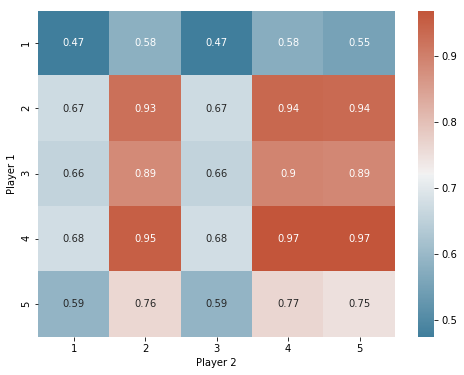

In [16]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(8, 6))
labels = np.arange(1, 6)
ax = sns.heatmap(sim_ratio, xticklabels=labels, yticklabels=labels, annot=True, cmap=cmap)
plt.xlabel('Player 2')
plt.ylabel('Player 1')
# cbar = ax.figure.colorbar(ax.collections[0])
plt.savefig('dqn_ratio.eps', format='eps', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [ ]:
# Simulated ratio below is close, but a little higher
# LAM0_ratio = np.array([1.46337919e-01, -2.37279434e-01,  2.10975799e-01, -8.21619733e-02, -2.02441740e-04])
# LAM5_ratio = np.array([0.47401543, 0.92656322, 0.65629609, 0.96937811, 0.74947158])